<a href="https://colab.research.google.com/github/JamesHorrex/SS_AI_TI/blob/master/SS_AITrader_CSCO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.2.0


In [3]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-u1gg8kd7
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-u1gg8kd7
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.087622f0d4888b557639c605c04a0e822874df5ba_-cp36-none-any.whl size=123835 sha256=6bd4575d9ab5558f18a03de08bb32ffe50026b9f6c5c612e189fbdd90ce56612
  Stored in directory: /tmp/pip-ephem-wheel-cache-boryl4mq/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [5]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [463]:
import pandas as pd 
stock='CSCO'
df=pd.read_csv('gdrive/My Drive/SS_AITrader/'+stock+'/df_'+stock+'_20drtn_features.csv')

In [464]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
0,2008-03-06,62.397171,54.909878,55.815241,43.146290,-53.777737,-49.590116,-35.798798,-55.714281,50.495869,42.192490,46.349161,40.715595,-1.359703,-1.885242,-2.919705,3.234153,3.726173,0.094766,-0.116780,-0.208357,-0.164541,-0.055720,-0.055720,-0.055720,-0.055720,-106.227129,-18.428157,26.340132,35.777021,-18.581282,-29.507989,0.041668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.248311,-0.042381,0.238573,-0.066409,0.321875,-0.012626,27.549999,2.949999,4.019999,-9.039720e+06,-9.039720e+06,-9.039720e+06,-9.039720e+06,0.126486,-0.062019,0.139714,0.012750,-0.052450,2.257,0.044,0.397,-0.480003,-0.720001,1.0
1,2008-03-07,65.759041,50.693239,59.147358,45.757193,-53.061199,-42.622901,-42.622901,-52.244891,58.997127,48.574327,57.327931,40.693165,0.710109,-0.741047,-1.148007,2.161018,3.122333,0.096553,-0.098014,-0.193914,-0.164548,-0.051422,-0.051422,-0.051422,-0.051422,-20.512384,-17.324079,36.978974,52.895102,-11.736879,-22.737085,0.358696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.236553,-0.032341,0.235849,-0.071282,0.311217,-0.021065,27.490000,-0.059999,0.949999,-2.041990e+06,-2.041990e+06,-2.041990e+06,-2.041990e+06,0.020641,-0.034336,-0.029325,-0.011496,-0.020744,2.141,-0.116,0.392,0.029999,-0.680000,0.0
2,2008-03-10,57.018615,55.547734,55.491717,42.394978,-79.452094,-47.540967,-47.540967,-54.693888,51.785589,48.738803,52.129835,38.920969,-0.497722,-1.153690,-1.680327,0.798322,1.911635,0.090966,-0.082864,-0.180684,-0.164381,-0.057041,-0.057041,-0.057041,-0.057041,-31.462904,-53.469948,26.278567,52.736284,-5.596748,-16.229799,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.236263,-0.023004,0.236124,-0.063590,0.311269,-0.020115,29.379999,1.889999,3.099998,-3.288044e+06,-3.288044e+06,-3.288044e+06,-3.288044e+06,-0.107275,-0.056693,-0.087480,-0.033174,-0.314969,2.138,-0.003,0.239,-0.040001,-0.709999,0.0
3,2008-03-11,69.671878,69.050962,62.754060,46.686647,-0.704241,-0.408172,-0.408172,-31.020420,52.325830,55.627940,52.183146,40.949317,4.835347,5.054298,3.540546,4.486913,6.930268,0.110422,-0.061261,-0.164469,-0.163531,0.031742,0.031742,0.031742,0.031742,166.666667,146.493734,133.413805,150.669632,3.469148,-6.662123,0.986301,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.334656,0.101014,0.289443,0.037932,0.334270,0.007442,26.360001,-3.019999,0.840000,2.352354e+07,2.352354e+07,2.352354e+07,2.352354e+07,-0.050450,0.064083,-0.043261,-0.008077,0.380716,2.156,0.018,0.172,0.290001,-0.380005,0.0
4,2008-03-12,65.853641,74.660827,62.494909,47.660969,-24.731228,-17.037069,-15.916982,-23.755682,50.219074,60.892596,52.339936,40.967227,-0.039762,4.272081,3.584668,0.761518,7.298331,0.140896,-0.036206,-0.146325,-0.162081,0.100143,0.100143,0.100143,0.100143,108.134927,171.495463,169.072892,173.781977,9.315301,-0.439042,0.233332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.283299,0.051845,0.288544,0.054162,0.331488,0.004693,27.219999,0.859999,2.619999,1.549237e+07,1.549237e+07,1.549237e+07,1.549237e+07,-0.187758,0.004365,-0.043948,-0.007206,-0.142997,2.043,-0.113,-0.170,-0.879997,-1.080002,0.0


In [465]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [466]:
from_date='2010-01-01'
to_date='2020-01-01'

In [467]:
df = df[pd.to_datetime(from_date) < df['timestamp'] ]
df = df[pd.to_datetime(to_date) > df['timestamp'] ]


In [468]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
445,2010-01-05,82.851113,60.508182,59.502688,57.253487,-19.117655,-14.285729,-14.285729,-14.285729,91.223769,58.027739,52.892309,56.919839,-0.445527,1.654258,2.076412,5.357908,1.738411,0.100812,0.040793,0.033626,0.103242,0.175501,0.175501,0.175501,0.175501,90.872428,153.921408,155.315250,185.683412,11.696236,13.252570,0.571430,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.176621,0.038913,0.168201,0.018676,0.178089,-0.015950,19.350000,-0.690001,-0.580000,7.883957e+06,7.883957e+06,7.883957e+06,7.883957e+06,0.201056,-0.036026,-0.074735,0.051996,-0.246087,3.695,-0.091,-0.092,0.090004,-0.009995,0.0
446,2010-01-06,75.195819,60.637786,53.355802,52.894276,-33.070860,-23.076931,-23.076931,-23.076931,78.642717,51.023109,47.833950,56.915594,-0.650935,2.005011,1.327800,3.299495,0.867414,0.124928,0.053564,0.039731,0.101892,0.188601,0.188601,0.188601,0.188601,47.735626,103.900898,119.247772,157.949237,11.904814,13.922302,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.179451,0.042029,0.170165,0.020638,0.178523,0.001473,19.160000,-0.190001,-0.850000,3.351136e+06,3.351136e+06,3.351136e+06,3.351136e+06,0.133380,-0.008884,-0.092563,0.038669,-0.208508,3.763,0.068,0.049,-0.130005,-0.340004,0.0
447,2010-01-07,73.468221,61.486017,54.280203,54.246612,-27.192950,-17.032941,-17.032941,-17.032941,68.113049,53.032401,48.670309,54.208398,0.450453,-0.648035,1.447479,3.284213,3.023945,0.145336,0.066148,0.046239,0.100773,0.205491,0.205491,0.205491,0.205491,8.620729,62.409057,90.402275,123.543430,14.548366,16.404696,0.900002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.179421,0.075961,0.158242,0.029873,0.178030,0.001795,19.059999,-0.100000,-0.900000,3.390241e+06,3.390241e+06,3.390241e+06,3.390241e+06,0.199516,0.142415,-0.009632,0.026254,-0.117161,3.777,0.014,0.033,0.420006,0.000000,0.0
448,2010-01-08,73.771420,71.167059,62.113098,54.030326,-17.142899,-9.890128,-9.890128,-9.890128,69.790411,61.238577,54.388525,57.131033,0.529960,0.325468,3.007516,3.700585,3.352889,0.164293,0.078994,0.053308,0.099911,0.226752,0.226752,0.226752,0.226752,53.528319,74.837559,99.165754,134.476981,17.334384,19.197382,0.911109,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.179286,0.058285,0.158799,0.025363,0.174245,-0.003778,18.129999,-0.930000,-3.550001,3.955172e+06,3.955172e+06,3.955172e+06,3.955172e+06,0.318501,0.243364,-0.011321,0.060269,0.240546,3.768,-0.009,-0.025,-0.440002,-0.389999,0.0
449,2010-01-11,70.280894,69.947265,60.219190,55.804436,-27.777709,-16.042749,-16.042749,-16.042749,72.202008,68.090185,54.595608,57.063022,-0.283859,0.696151,-0.405024,2.629387,2.715119,0.177998,0.090719,0.060307,0.099230,0.235241,0.235241,0.235241,0.235241,119.967861,85.745178,103.512959,137.608772,20.237948,21.793865,0.375001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.180600,0.012547,0.159462,-0.013469,0.172459,-0.017278,17.549999,-0.580000,-2.490002,1.800217e+06,1.800217e+06,1.800217e+06,1.800217e+06,0.245665,0.275221,-0.007975,0.041716,-0.083419,3.793,0.025,0.007,-0.470001,-0.529999,0.0


In [469]:
df.drop(['timestamp'], inplace=True, axis=1)

In [470]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

In [471]:
train_labels = train_dataset.pop('labels')
test_labels = test_dataset.pop('labels')

In [472]:
train_labels.head()

1856    1.0
2747    0.0
898     0.0
765     0.0
1100    0.0
Name: labels, dtype: float64

In [473]:
from sklearn.utils import compute_class_weight
def get_sample_weights(y):
      y = y.astype(int)  # compute_class_weight needs int labels
      class_weights = compute_class_weight('balanced', np.unique(y), y)

      print("real class weights are {}".format(class_weights), np.unique(y))
      print("value_counts", np.unique(y, return_counts=True))
      sample_weights = y.copy().astype(float)
      for i in np.unique(y):
          sample_weights[sample_weights == i] = class_weights[i]  # if i == 2 else 0.8 * class_weights[i]
            # sample_weights = np.where(sample_weights == i, class_weights[int(i)], y_)

      return sample_weights


In [474]:
get_sample_weights(train_labels)

real class weights are [1.13425926 0.89416058] [0 1]
value_counts (array([0, 1]), array([ 864, 1096]))


1856    0.894161
2747    1.134259
898     1.134259
765     1.134259
1100    1.134259
          ...   
2051    0.894161
1301    0.894161
2192    0.894161
1640    0.894161
2882    0.894161
Name: labels, Length: 1960, dtype: float64

In [475]:
SAMPLE_WEIGHT=get_sample_weights(train_labels)

real class weights are [1.13425926 0.89416058] [0 1]
value_counts (array([0, 1]), array([ 864, 1096]))


In [476]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()

In [477]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [478]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from operator import itemgetter

k=20
list_features = list(normed_train_data.columns)
select_k_best = SelectKBest(f_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)

selected_features_anova

('rsi_40',
 'wr_20',
 'trix_10',
 'trix_15',
 'macd10',
 'macd15',
 'macd20',
 'macd40',
 'cci_25',
 'kst_20',
 'kst_40',
 'bb_l20',
 'realised_vol_10',
 'realised_vol_20',
 'realised_vol_40',
 'vix_level',
 'cmf_10',
 'cmf_15',
 'cmf_20',
 'curve')

In [479]:
select_k_best = SelectKBest(mutual_info_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)
selected_features_mic

('rsi_10',
 'rsi_20',
 'mfi_10',
 'mfi_20',
 'roc_1',
 'roc_5',
 'roc_20',
 'trix_15',
 'trix_40',
 'cci_15',
 'bb_h20',
 'realised_vol_10',
 'realised_vol_20',
 'realised_vol_40',
 'vix_level',
 'forcei_15',
 'forcei_20',
 'forcei_40',
 'cmf_15',
 'curve')

In [480]:
list_features = list(normed_train_data.columns)
feat_idx = []
for c in selected_features_mic:
      feat_idx.append(list_features.index(c))

feat_idx = sorted(feat_idx)
X_train_new=normed_train_data.iloc[:, feat_idx]
X_test_new=normed_test_data.iloc[:, feat_idx]
#kbest=SelectKBest(f_classif, k=10)
#X_train_new = kbest.fit_transform(normed_train_data, train_labels)
#X_test_new = kbest.transform(normed_test_data)

X_test_new.shape
X_test_new.head()

,rsi_10,rsi_20,mfi_10,mfi_20,roc_1,roc_5,roc_20,trix_15,trix_40,cci_15,bb_h20,realised_vol_10,realised_vol_20,realised_vol_40,vix_level,forcei_15,forcei_20,forcei_40,cmf_15,curve
445,1.473545,0.424727,2.046190,0.042554,-0.302996,0.538344,0.125121,0.055951,0.590913,1.238605,-0.262044,-0.305450,-0.524884,-0.616337,0.445087,0.314448,0.314448,0.314448,-0.332522,2.013397
448,1.014410,0.596838,0.904895,0.147968,0.315614,0.811985,0.365990,0.227426,0.564411,0.738125,-0.262044,-0.284153,-0.610881,-0.658496,0.226020,0.181683,0.181683,0.181683,1.182530,2.093196
452,0.604084,0.644698,0.837423,0.683720,0.777383,0.431303,0.799809,0.384487,0.546650,1.042409,-0.262044,0.094247,-0.494804,-0.675027,0.136238,0.323167,0.323167,0.323167,1.248340,2.006838
469,0.639552,-0.556265,1.539068,0.509921,1.031964,1.038809,-0.558945,-0.768114,0.177954,0.593250,-0.262044,0.118225,0.520881,-0.074739,1.639183,0.535047,0.535047,0.535047,-1.214792,1.836308
470,0.550966,-0.594972,1.162671,0.461768,-0.365543,0.807102,-0.405499,-0.728537,0.151700,0.700055,-0.262044,0.130615,0.477482,-0.078019,1.531445,0.298649,0.298649,0.298649,-1.265846,1.902990


In [481]:
def build_model(hidden_dim,dropout=0.5):
    ## input layer
    inputs=tf.keras.Input(shape=(X_train_new.shape[1],))


    h1= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(inputs)
    h2= tf.keras.layers.Dropout(dropout)(h1)
    h3= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h2)
    h4= tf.keras.layers.Dropout(dropout)(h3)
    h5= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h4)
    h6= tf.keras.layers.Dropout(dropout)(h5)
    h7= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(h6)

    ##output
    outputs=tf.keras.layers.Dense(units=2,activation='softmax')(h7)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [482]:
tf.random.set_seed(1)

criterion = tf.keras.losses.sparse_categorical_crossentropy

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model = build_model(hidden_dim=64)

model.compile(optimizer=optimizer,loss=criterion,metrics=['accuracy'])

In [483]:
example_batch = X_train_new[:10]
example_result = model.predict(example_batch)
example_result

array([[0.586402  , 0.413598  ],
       [0.50468314, 0.4953169 ],
       [0.55996644, 0.44003353],
       [0.54908913, 0.45091087],
       [0.5585241 , 0.44147593],
       [0.5579984 , 0.4420016 ],
       [0.5519473 , 0.4480527 ],
       [0.48483318, 0.51516676],
       [0.49603182, 0.5039682 ],
       [0.5969391 , 0.40306088]], dtype=float32)

In [484]:
EPOCHS=200
BATCH_SIZE=20

history = model.fit(
  X_train_new, train_labels,
  epochs=EPOCHS, batch_size=BATCH_SIZE ,sample_weight=SAMPLE_WEIGHT,shuffle=True,validation_split = 0.2, verbose=1,
  callbacks=[tfdocs.modeling.EpochDots()])

Epoch 1/200
66/79 [========================>.....] - ETA: 0s - loss: 0.7418 - accuracy: 0.4962
Epoch: 0, accuracy:0.4974,  loss:0.7370,  val_accuracy:0.5153,  val_loss:0.6851,  
79/79 [==============================] - 1s 7ms/step - loss: 0.7370 - accuracy: 0.4974 - val_loss: 0.6851 - val_accuracy: 0.5153
Epoch 2/200
79/79 [==============================] - 0s 6ms/step - loss: 0.7038 - accuracy: 0.5338 - val_loss: 0.6816 - val_accuracy: 0.5434
Epoch 3/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5198 - val_loss: 0.6758 - val_accuracy: 0.5867
Epoch 4/200
79/79 [==============================] - 0s 6ms/step - loss: 0.6872 - accuracy: 0.5497 - val_loss: 0.6745 - val_accuracy: 0.5510
Epoch 5/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6891 - accuracy: 0.5446 - val_loss: 0.6747 - val_accuracy: 0.5561
Epoch 6/200
79/79 [==============================] - 0s 6ms/step - loss: 0.6821 - accuracy: 0.5529 - val_loss: 0.6718 - val_accur

In [485]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
195,0.353529,0.843750,0.510305,0.755102,195
196,0.361792,0.839923,0.511882,0.742347,196
197,0.384143,0.833546,0.490895,0.757653,197
198,0.351294,0.850765,0.520228,0.757653,198
199,0.388334,0.822704,0.499400,0.757653,199


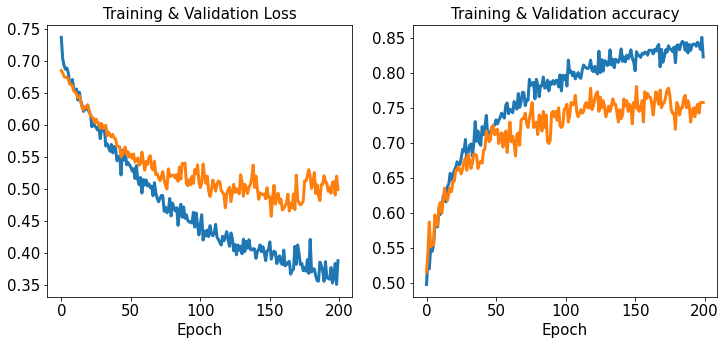

In [486]:
import matplotlib.pyplot as plt

hist=history.history

fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(1,2,1)
ax.plot(hist['loss'],lw=3)
ax.plot(hist['val_loss'],lw=3)
ax.set_title('Training & Validation Loss',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax=fig.add_subplot(1,2,2)
ax.plot(hist['accuracy'],lw=3)
ax.plot(hist['val_accuracy'],lw=3)
ax.set_title('Training & Validation accuracy',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
plt.show()




In [32]:
!pip install shap

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394130 sha256=fa7a3695c4152743202e7de8bd95b7d76cec14ad3ea03f3ef255b7369251cec7
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [487]:
import shap

explainer = shap.DeepExplainer(model, np.array(X_train_new))

In [488]:
shap_values  = explainer.shap_values(np.array(X_test_new))

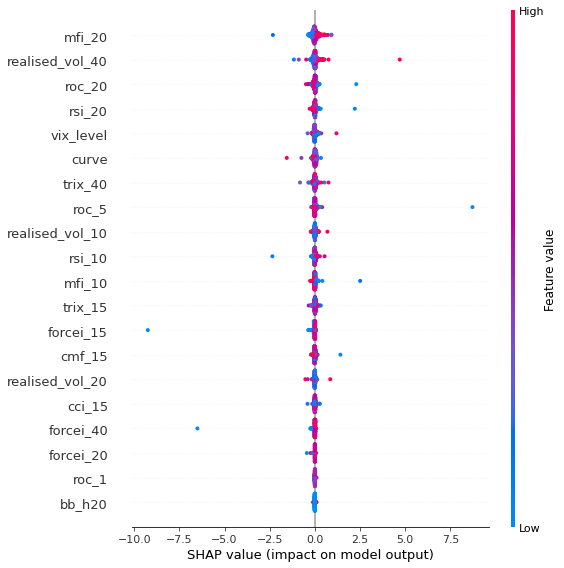

In [489]:
shap.summary_plot(shap_values[1], X_test_new)

In [490]:
pred=model.predict(X_test_new)
pred.argmax(axis=1)

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [491]:
from sklearn.metrics import classification_report, confusion_matrix

cm=confusion_matrix(test_labels, pred.argmax(axis=1))

Confusion Matrix


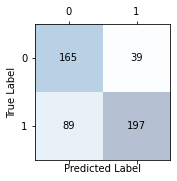

In [492]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [493]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('Recall: %.3f' % recall_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('F1: %.3f' % f1_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

Precision: 0.835
Recall: 0.689
F1: 0.755


In [494]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
import xgboost as xgb
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

In [495]:
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic'))
])

In [496]:
search_space = [
  {
    'clf__n_estimators': [200],
    'clf__learning_rate': [0.05, 0.5, 0.1],
    'clf__max_depth': range(3, 10),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [mutual_info_classif,f_classif],
    'fs__k': [30,40],
  }
]

In [498]:
kfold = KFold(n_splits=4, shuffle=True, random_state=42)

In [499]:
scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score)}

In [500]:
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

In [501]:
model = grid.fit(normed_train_data, train_labels)

Fitting 4 folds for each of 504 candidates, totalling 2016 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 2016 out of 2016 | elapsed: 20.3min finished


In [502]:
import pickle

# Dictionary of best parameters
best_pars = grid.best_params_
# Best XGB model that was found based on the metric score you specify
best_model = grid.best_estimator_
# Save model
pickle.dump(grid.best_estimator_, open('gdrive/My Drive/SS_AITrader/'+stock+'/xgb_'+stock+'_log_reg.pickle', "wb"))

In [503]:
predict = model.predict(normed_test_data)
print('Best AUC Score: {}'.format(model.best_score_))
print('Accuracy: {}'.format(accuracy_score(test_labels, predict)))
cm=confusion_matrix(test_labels,predict)

Best AUC Score: 0.927092274803014
Accuracy: 0.8857142857142857


Confusion Matrix


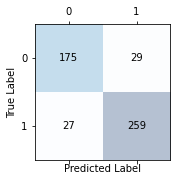

In [504]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [505]:
print(model.best_params_)

{'clf__colsample_bytree': 0.2, 'clf__gamma': 0.2, 'clf__learning_rate': 0.1, 'clf__max_depth': 8, 'clf__n_estimators': 200, 'fs__k': 40, 'fs__score_func': <function mutual_info_classif at 0x7f9d435a61e0>}


In [506]:
k=40
select_k_best = SelectKBest(mutual_info_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)

list_features = list(normed_train_data.columns)
feat_idx = []
for c in selected_features_mic:
      feat_idx.append(list_features.index(c))

feat_idx = sorted(feat_idx)
X_train_new=normed_train_data.iloc[:, feat_idx]
X_test_new=normed_test_data.iloc[:, feat_idx]




In [507]:
model_opt = xgb.XGBClassifier(max_depth=8,
                        objective='binary:logistic',
                        n_estimators=200,
                        learning_rate = 0.1,
                        colsample_bytree= 0.2,
                        gamma= 0.2)
eval_set = [(X_train_new, train_labels), (X_test_new, test_labels)]
model_opt.fit(X_train_new, train_labels, early_stopping_rounds=15, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.210714	validation_0-logloss:0.657021	validation_1-error:0.363265	validation_1-logloss:0.675198
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 15 rounds.
[1]	validation_0-error:0.166327	validation_0-logloss:0.637441	validation_1-error:0.359184	validation_1-logloss:0.667856
[2]	validation_0-error:0.15051	validation_0-logloss:0.618438	validation_1-error:0.340816	validation_1-logloss:0.657338
[3]	validation_0-error:0.096939	validation_0-logloss:0.585049	validation_1-error:0.267347	validation_1-logloss:0.634321
[4]	validation_0-error:0.092347	validation_0-logloss:0.56073	validation_1-error:0.263265	validation_1-logloss:0.621385
[5]	validation_0-error:0.081633	validation_0-logloss:0.549214	validation_1-error:0.244898	validation_1-logloss:0.617156
[6]	validation_0-error:0.072449	validation_0-logloss:0.527671	validation_1-error:0.257143	validation_1-logloss:0.6096

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2, gamma=0.2,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [508]:

# make predictions for test data
y_pred = model_opt.predict(X_test_new)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.94%


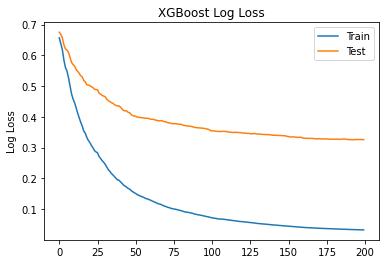

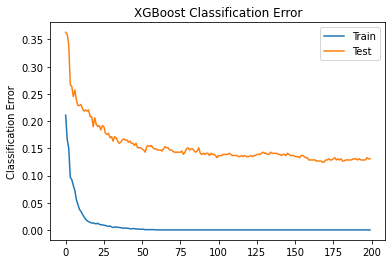

In [509]:
from matplotlib import pyplot

results = model_opt.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [510]:
shap_values = shap.TreeExplainer(model_opt).shap_values(X_test_new) 

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


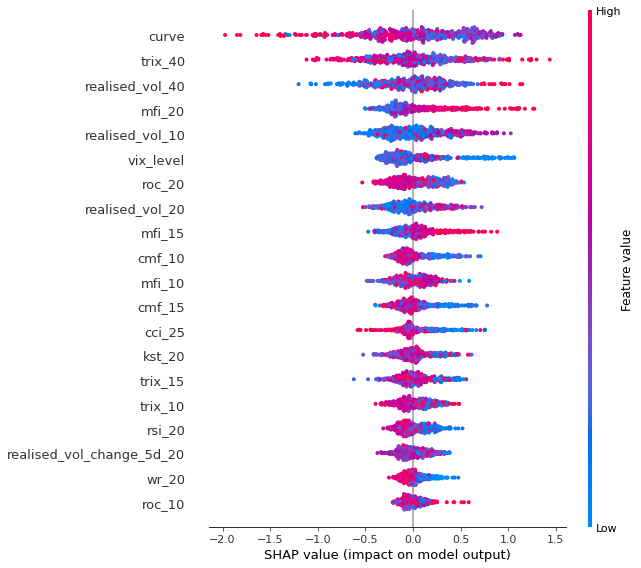

In [511]:
shap.summary_plot(shap_values, X_test_new)

In [512]:
predict = model_opt.predict(X_test_new)

cm=confusion_matrix(test_labels,predict)

Confusion Matrix


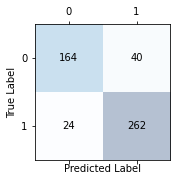

In [513]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()